# Ranked Strategic Classification 🦚

## Introduction

In our project we tackle the problem of Stategic classification with user dependant responses. 

We introduce user dependance through competition on $k$ available spots which are given to the top-k rated users.

This problem appears in our daily life in multiple places such as acceptance into universities and job interviews, where the users compete for a few available spots.

These users are strategic, and can improve their ranking by changing their features. In the example of job interview, can for example create a specialized CV which they know will help them in getting into the job.

## Setting

 ### Notations
- Time is assumed to be discrete and denoted by $t\in\{0,1,...\}$
- Each user $i$ has initial features $x_i(0)\in \mathbb{R}^d$
- Each user $i$ updates his features at each time $t$ with a function $x_i(t) = \Delta_h(x_i(0))$.
  
<ins>Note:</ins> For simplification, the user always updates his features based on his features at $t=0$.
- The set of user features at time $t$ is denoted by $X_t$
- Each user has a ground truth rating $r(x_i(0))\in[0,1]$
- We train a model to predict the true ratings $r_{\theta}(x_i(t))$
- Denote the sorted indices of the users based on $r_{\theta}(x_i(t))$ by $s_i(t) = \text{argsort}(\{r_\theta(x(t))\}_{x(t)\in X_t})[i]$

Given all of the users and their features, the system predicts the rating for each user, $r_\theta(x_i(t))$, and accepts the top-$k$ rated users $\{x_{s_1(t)},...,x_{s_k(t)}\}$. 

The users are able to change their features with the following function: $\Delta_h(x)$



## Environment

We model the environment based on the environment from the paper: *S. Levanon, N. Rosenfeld: "Strategic Classification Made Practical", 2021*

We assume a behavioral model for the user strategic response $\Delta_h(\cdot)$. Given the ratings at time $t$ we calculate 2 thresholds:

$$
T_{low} = r_\theta(x_{s_k(t)}(t)), \quad T_{high} = r_\theta(x_{s_{k'}(t)}(t)) 
$$

Where $k'< k$ is a positive integer. These thresholds are used to model the behavioral responses. 

We hypothesize that users will not be satisfied by sitting on the low threshold and will want acceptance confidence at the higher rating threshold. Using this we design the following reward function: 

$$h(r) = q\cdot\sigma^*_{\tau}\left(\frac{r-T_{low}}{\tau_{low}}\right) + (1-q)\cdot\sigma^*_{\tau}\left(\frac{r-T_{high}}{\tau_{high}}\right)$$

Where $q\in[0,1]$, and $\sigma(\cdot)$ is a sigmoid function that will be discussed in the CCP section. This gives small reward $q$ for acceptance and the rest is given for passing the higher threshold.

The $\tau$ parameters express the softness of threshold; small $\tau$ will give a step like reward and large $\tau$ will give a smoother reward.

The user responses are modeled as 

$$\Delta_h(x) = \underset{x'}{\text{argmax }} h(r_\theta(x')) - c(x,x')$$

Where $c(\cdot,\cdot)$ is a convex cost function for feature change, we use euclidean distance.

In [23]:
%matplotlib notebook
%matplotlib inline
import cvxpy as cp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import zero_one_loss, confusion_matrix
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import json
import random
import math
import os, psutil
from datetime import datetime
from sklearn.metrics import ndcg_score, precision_score, recall_score, mean_squared_error

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
SEED = 0

# Utils

A few useful utilities:

In [2]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    torch.manual_seed(0)
    np.random.seed(0)
    data = torch.cat((Y, X), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc



# Gain & Cost functions

In this section we implement the score functions and based on it, a differientiable sigmoid-like proxy for the sign operation in the $h$ function:

$$\sigma_\tau^*(z) = 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1} - 0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$$

We denote $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{low})+1)^2+1}$ with $f(x)$ and $0.5 \cdot \sqrt{(\tau^{-1}(z-T_{high})-1)^2+1}$ with $g(x)$.

This function can be written as a sum of convex and concave funcitons, a property which is essential to the CCP method.

In [3]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope, T):
    return 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b)-T) + 1)]), 2)
    # return 0.5*cp.sqrt(1+cp.square((slope*(score(x, w, b) - T) + 1)))

def g(x, w, b, slope, T):
    res = 0.5*cp.norm(cp.hstack([1, (slope*(score(x, w, b) - T) - 1)]), 2)
    # score_expr = score(x, w, b)
    # score_slope = slope*(score(x, w, b) - T)
    # score_vec = cp.hstack([1, (slope*(score(x, w, b) - T) - 1)])
    # print('res')
    # print("Nonnegative? ", res.is_nonneg())
    # print("Convex? ", res.is_convex())
    # print("Affine? ", res.is_affine())
    # print("NonPositive? ", res.is_nonpos())
    # print("DCP? ", res.is_dcp())
    # print('score_expr')
    # print("Nonnegative? ", score_expr.is_nonneg())
    # print("Convex? ", score_expr.is_convex())
    # print("Affine? ", score_expr.is_affine())
    # print("NonPositive? ", score_expr.is_nonpos())
    # print('score_slope')
    # print("Nonnegative? ", score_vec.is_nonneg())
    # print("Convex? ", score_slope.is_convex())
    # print("Affine? ", score_slope.is_affine())
    # print("NonPositive? ", score_slope.is_nonpos())
    # print('score_vec')
    # print("Nonnegative? ", score_vec.is_nonneg())
    # print("Convex? ", score_vec.is_convex())
    # print("Affine? ", score_vec.is_affine())
    # print("NonPositive? ", score_vec.is_nonpos())
    # print(f"x's shape={x.shape}")
    # print(f"score's shape={(score(x, w, b)-T).shape}")
    # print(f"g's shape={cp.hstack([1, (slope*(score(x, w, b)-T) - 1)]).shape}")
    # print(f"res's shape={res}")
    return res

def c(x, r, x_dim, scale):
    return (scale)*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope, T):
    return 0.5*cp.multiply(slope*((slope*(score(x, w, b)-T) + 1)/cp.sqrt((slope*(score(x, w, b)-T) + 1)**2 + 1)), w)

def f_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones(x.shape[0]), slope*(score(x, w, b) - T) + 1]), 2, axis=0)

def g_batch(x, w, b, slope, T):
    return cp.norm(cp.vstack([np.ones((1, x.shape[0])), cp.reshape((slope*(score(x, w, b)-T) - 1), (1, x.shape[0]))]), 2, axis=0)

def c_batch(x, r, x_dim, scale):
    return (scale)*cp.square(cp.norm(x-r, 2, axis=1))

def f_derivative_batch(x, w, b, slope, T):
    nablas = 0.5*slope*((slope*(score(x, w, b) - T) + 1)/cp.sqrt((slope*(score(x, w, b) - T) + 1)**2 + 1))
    return cp.reshape(nablas, (nablas.shape[0], 1))@cp.reshape(w, (1, x.shape[1]))

# ------------------------------------- Our added functions -------------------------------------
# summing 2 sigmoids to model initial acceptance and higher acceptance in order to model user behavior of wanting to have some margin from min requirements

def f_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f(x, w, b, slope_high, Thresh_high)

def g_tot(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g(x, w, b, slope_high, Thresh_high)

def f_tot_derivative(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    f_der = cp.pos(acp_reward) * f_derivative(x, w, b, slope_low, Thresh_low) + cp.pos(1-acp_reward) * f_derivative(x, w, b, slope_high, Thresh_high)
    return f_der

def f_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * f_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * f_batch(x, w, b, slope_high, Thresh_high)

def g_tot_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    # expr1 = cp.pos(acp_reward) * g_batch(x, w, b, slope_low, Thresh_low)
    # expr2 = cp.pos(1-acp_reward) * g_batch(x, w, b, slope_high, Thresh_high)
    # expr_tot = expr1 + expr2
    # print('expr1')
    # print('DCP?', expr1.is_dcp())
    # print('expr2')
    # print('DCP?', expr2.is_dcp())
    # print('expr_tot')
    # print('DCP?', expr_tot.is_dcp())
    # acp_reward and 1-acp_reward must be explicitly stated as positive to make the DCP ruleset
    # complie the expression as convex, otherwise it may be non-convex
    return cp.pos(acp_reward) * g_batch(x, w, b, slope_low, Thresh_low)+ cp.pos(1-acp_reward) * g_batch(x, w, b, slope_high, Thresh_high)

def f_tot_derivative_batch(x, w, b, slope_low, slope_high, Thresh_low, Thresh_high, acp_reward):
    return acp_reward * f_derivative_batch(x, w, b, slope_low, Thresh_low)+ (1-acp_reward) * f_derivative_batch(x, w, b, slope_high, Thresh_high)

# -----------------------------------------------------------------------------------------------

# CCP classes

Defining a CCP class based on the one implemented in the paper referenced above.

Convex-Concave Procedure (in short CCP) is an iterative method for solving optimization problems that are expressed as a difference of convex functions, like the one we have in our problem.

It does so by iterating through a sequence of concave-relaxed problems (using Taylor series to linearize on of the functions), a process that guarantees convergence to local maxima.

We use $h(r)$ which is **a linear combination** of the sigmoid-like proxy described above to model the users behavior.

As reminded above, this sigmoid function can be written as a difference of convex functions and is therefore perfect for CCP. 

Because $h(r)$ is a linear combination of sigmoids, it can also be discribed as a difference of convex functions and we can use CCP.

In [4]:
class CCP_rank:
    def __init__(self, x_dim, batch_size, funcs, scale):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        self.batch_size = batch_size

        # self.x = cp.Variable((batch_size, x_dim))
        # self.xt = cp.Parameter((batch_size, x_dim))
        # self.r = cp.Parameter((batch_size, x_dim)) # old reference point (initial x)
        self.x = cp.Variable((batch_size, x_dim))
        self.xt = cp.Parameter((batch_size, x_dim))
        self.r = cp.Parameter((batch_size, x_dim))
        
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1) # bias parameter
        # -------------------- adding our function's params --------------------
        self.slope_low = cp.Parameter(1) # scale of the low threshold sigmoid
        self.slope_high = cp.Parameter(1) # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = cp.Parameter(1) # defines the reward for passing initial threshhold - q in the equations 
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        # target = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
        #                 self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T)) - self.g(self.x, self.w,
        #                 self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward)-self.c(self.x, self.r,
        #                 x_dim, scale)
        f = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T))
        g = self.g(self.x, self.w,
                        self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward)
        cost = self.c(self.x, self.r, x_dim, scale)
        target = cp.diag(self.x@(self.f_derivative(self.xt, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward).T)) - self.g(self.x, self.w,
                        self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward) - self.c(self.x, self.r,
                        x_dim, scale)
        # target = - self.g(self.x, self.w,
        #                 self.b, self.slope_low, self.slope_high, self.T_low, self.T_high, self.acp_reward)
        # # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        # define the problem's objective
        self.prob = cp.Problem(cp.Maximize(cp.sum(target)), constraints)

    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)/self.batch_size
        return self.x.value

    def optimize_X(self, X, w, b, slope_low, slope_high, T_low, T_high, acp_reward):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        T_low = T_low.detach().numpy()
        T_high = T_high.detach().numpy()
        

        # converting our params into numpy arrays with 1 value
        slope_low = np.full(1, slope_low)
        slope_high = np.full(1, slope_high)
        T_low = np.full(1, T_low)
        T_high = np.full(1, T_high)
        acp_reward = np.full(1, acp_reward)

        X = X.numpy()

        self.w.value = w
        self.b.value = b
        self.slope_low.value = slope_low
        self.slope_high.value = slope_high
        self.T_low.value = T_low
        self.T_high.value = T_high
        self.acp_reward.value = acp_reward

        # return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

        return torch.from_numpy(self.ccp(X))

### Delta 
This module uses the CCP procedure to compute the user responses.

In [5]:
class DELTA():

    def __init__(self, x_dim, funcs, scale, slope_low, slope_high, acp_reward):
        self.g = funcs["g"]
        self.c = funcs["c"]

        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        # -------------------- adding our function's params --------------------
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.T_low = cp.Parameter(1) # low threshold of the sigmoid
        self.T_high = cp.Parameter(1) # high threshold of the sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        # ----------------------------------------------------------------------

        # -------------------- defining our target function --------------------
        target = self.x@self.f_der-self.g(self.x, self.w, self.b, 
                        self.slope_low, self.slope_high, self.T_low, 
                        self.T_high, self.acp_reward)-self.c(self.x, self.r, x_dim, scale)
        # ----------------------------------------------------------------------
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.T_low, self.T_high], variables=[self.x])
        

    def optimize_X(self, X, w, b, F_DER, T_low, T_high):
        return self.layer(X, w, b, F_DER, T_low, T_high)[0]

# Model

In [51]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, batch_size, env, strategic=False):
        torch.manual_seed(0)
        np.random.seed(0)

        super(MyStrategicModel, self).__init__()
        self.env = env
        self.x_dim = env.n_features
        self.batch_size = batch_size
        # not sure why test slopes are different from test and train - still done here because original SCMP did it 
        self.train_slope_low, self.train_slope_high, self.test_slope_low, self.test_slope_high = env.slope_low, env.slope_high, 5*env.slope_low, 5*env.slope_high
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(self.x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/self.x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.acp_reward = env.acp_reward
        self.strategic = strategic
        self.ccp = CCP_rank(self.x_dim, batch_size, env.funcs_batch, env.scale)
        self.delta = DELTA(self.x_dim, env.funcs, env.scale, self.train_slope_low, self.train_slope_high, self.acp_reward)
        self.ccp_time = 0
        self.total_time = 0
        
        
    def forward(self, X, use_delta=False, evaluation=False):
        
        if self.strategic:
            t1 = time.time()
            # currently not distinguishing between train and test slopes
            Xt, X_opt = self.env.full_dynamic_update(X, self.w, self.b, use_delta)
            
            self.ccp_time += time.time()-t1
            X_opt = Xt if evaluation else X_opt
            output = self.score(X_opt)
        else:
            output = self.score(X)
        return output

    # def optimize_X(self, X, evaluation=False):
    #     slope = self.eval_slope if evaluation else self.train_slope
    #     return self.ccp.optimize_X(X, self.w, self.b, slope)

    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm

    def score(self, x):
        return x@self.w + self.b

    def get_f_ders(self, XT, slope):
        nablas = 0.5*slope*((slope*self.score(XT) + 1)/torch.sqrt((slope*self.score(XT) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))

    def calc_accuracy(self, R, R_pred):
        # calculating acceptance label from ratings
        Y = self.rating_to_accept(R)
        Y_pred = self.rating_to_accept(R_pred)

        # calculating accuracy based on Y and Y_pred
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./len(Y)
        return acc
    
    def calc_burden(self, X_0, Y):
        # calculating the burden in a similar fashion to the original paper
        X_t, _ = self.env.full_dynamic_update(X_0, self.w, self.b, use_delta=False)
        # i.e., only taking those who were supposed to get accepted
        X_0_pos = X_0[Y==1]
        X_t_pos = X_t[Y==1]
        if len(X_0_pos) == 0:
            return 0
        # and measure how much they moved (although they are supposed to get accepted without effort) in order to get accepted
        return torch.mean(torch.sum((X_0_pos-X_t_pos)**2, dim=1)).detach().numpy()

    
    # convert rating vector to acceptance
    def rating_to_accept(self, R):
        # calculating Y_pred out of score_pred
        Y = np.zeros_like(R)
        # getting the top-k values
        top_k_ranking_indices = np.argsort(R)[-self.env.k:]
        Y[top_k_ranking_indices] = 1
        return Y
        
    # def evaluate(self, X, Y):
    #     return self.calc_accuracy(Y, self.forward(X, evaluation=True))

    # we use mean squared loss between provided ratings
    def loss(self, Y, Y_pred):
        return torch.mean((Y-Y_pred) ** 2)

    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment

        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)

        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')

        with open(path + "/info.txt", "w") as f:
            f.write(info)

    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()

    # we fit according to score as a proxy to the ranking for simplicity reasons
    def fit(self, path, X, R, Xval, Rval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        # labels are the true rating 
        # loading the datasets
        train_dset = TensorDataset(X, R)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        test_dset = TensorDataset(Xval, Rval)
        test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=True)

        # optimizing the NN
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []

        # adding our score metrics (ndcg, precision, recall...)
        our_train_metrics = []
        our_test_metrics = []

        # defining stopping conditions
        # best_val_error = 1
        best_val_loss = np.inf
        consecutive_no_improvement = 0

        # runnning epochs
        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Rbatch in train_loader:
#                 try:
                opt.zero_grad()
                Rbatch_pred = self.forward(Xbatch)
                l = self.loss(Rbatch, Rbatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    # calculating accuracy
                    e = self.calc_accuracy(Rbatch, Rbatch_pred)

                    # calculating different scores to the ranking
                    Y = self.rating_to_accept(Rbatch)
                    Y_pred = self.rating_to_accept(Rbatch_pred)
                    our_train_metrics.append({
                        "epoch num" : epoch,
                        "accuracy" : e,
                        "loss" : l.item(),
                        "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rbatch_pred, 0)),
                        "precision" : precision_score(Y, Y_pred),
                        "recall" : recall_score(Y, Y_pred),
                        "burden" : self.calc_burden(Xbatch, Y),
                    })
                    
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()
#                 except:
#                     print("failed")

            with torch.no_grad():
                total_loss = 0
                total_error = 0
                batch = 0
                for Xbatch, Rbatch in test_loader:
#                     try:
                    Rval_pred = self.forward(Xbatch, evaluation=True)
                    val_loss = self.loss(Rbatch, Rval_pred).item()
                    total_loss += val_loss
                    val_error = 1-self.calc_accuracy(Rbatch, Rval_pred)
                    total_error += val_error
                    batch += 1
#                     except:
#                         print("failed")
                avg_loss = total_loss/batch
                avg_error = total_error/batch
                # calculating different scores to the ranking
                Y = self.rating_to_accept(Rbatch)
                Y_pred = self.rating_to_accept(Rval_pred)
                our_test_metrics.append({
                    "epoch num" : epoch,
                    "accuracy" : 1 - avg_error,
                    "loss" : avg_loss,
                    "ndcg" : ndcg_score(np.expand_dims(Rbatch, 0), np.expand_dims(Rval_pred, 0)),
                    "precision" : precision_score(Y, Y_pred),
                    "recall" : recall_score(Y, Y_pred),
                    "burden" : self.calc_burden(Xbatch, Y),
                })
                val_losses.append(avg_loss)
                val_errors.append(avg_error)
                if avg_loss < best_val_loss:
                        consecutive_no_improvement = 0
                        best_val_error = avg_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\nslope low: {}\nslope high: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope_low, self.train_slope_high, opt_kwargs["lr"], avg_loss, avg_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break

            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))

        self.total_time = time.time()-total_time
        print("training time: {} seconds".format(self.total_time))
        # returning our metrics in addition to the errors
        return our_train_metrics, our_test_metrics
    
    

### Data Generation
- user features generated randomly
- ground truth rating model is $r(x)=u^Tx$ 
- observed noisy ratings $\tilde{r}(x)=r(x)+\epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2_\epsilon)$.

## Training Environment

Each training step will include several dynamic iterations (user feature updates) and after that a single update of the system features $\theta$.

Pseudocode of the training:

- until model convergence:
    - for $t = 0:T$
        - Get $T_{low},T_{high}$ from $r_{\theta}(\cdot)$ and $x_t$
        - $x_{t+1} = \Delta_h(x_t,T_{low},T_{high})$
    - Update model based on $x_T,r$
    - $w,b = GD(x_T,r)$

In test time we will evaluate features after the dynamic iteration i.e., $x_T$.

In [8]:
class RankingEnv():
    """
    Strategic Classification Environment
    """
    def __init__(self, noisyscale, n_features, k, k_tag, n_users, slope_low, slope_high, acp_reward, funcs, funcs_batch, scale):
        self.noisyscale = noisyscale
        self.n_features = n_features
        self.k = k  # k is number of accepted users
        self.k_tag = k_tag  # k' < k sets the threshold of confidant acceptance
        self.system_attributes = torch.randn(size=(n_features,))*0.1  # u system rating vector, multiplying in 0.1, the scale
        
        # system variables 
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(n_features, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/n_features)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        
        # Delta parameters
        self.slope_low = slope_low # scale of the low threshold sigmoid
        self.slope_high = slope_high # scale of the high threshold sigmoid
        self.acp_reward = acp_reward # the relation between the 2 slopes - defines the reward for passing initial threshhold
        self.scale = scale  # cost function scale
        self.funcs = funcs
        self.funcs_batch = funcs_batch
        self.ccp = CCP_rank(n_features, batch_size=n_users, funcs=funcs_batch, scale=scale)
        self.delta = DELTA(n_features, funcs, scale, slope_low, slope_high, acp_reward)

        
        # user variables 
        self.n_users = n_users
        # self.users_initial = self.generate_users(n_users=n_users)
        # self.users_current = self.users_initial
        self.t = 0  # time indicator
        self.T_max = 5  #  number of dynamic iterations
    
    def generate_dataset(self):
        X = self.generate_users(self.n_users)
        R = self.rating(X)
        y = self.get_true_accepted(X)
        return X, R, y
        
    def generate_users(self, n_users):
        return torch.randn(size = (n_users, self.n_features)) * 0.1 # multiplying in 0.1, the scale
    
    # def get_users_current(self):
    #     return self.users_current
    
    # def get_users_initial(self):
    #     return self.users_initial
    
    def rating(self, users):
        # return noisy users rating, when the noise is normally distributed
        clean_ratings = users@self.system_attributes.T
        noise = torch.randn_like(clean_ratings) * self.noisyscale # multiplying in the noisyscale
        return clean_ratings + noise
    
    def get_thresh(self, X):
        ranking = self.score(X)
        # reversing the sort into a descending order
        sorted_ranking , _= torch.sort(ranking, descending=True)
        # calculate thresholds from k and k_tag
        return sorted_ranking[self.k-1].reshape(1), sorted_ranking[self.k_tag-1].reshape(1)
    
    # returns ground truth ratings for users
    def get_true_accepted(self, X):
        ranking = self.rating(X)
        acceptance = torch.zeros_like(ranking)
        # sort ranking in descending order
        _ , sorted_indices = torch.sort(ranking, descending=True)
        acceptance[sorted_indices[:self.k]] = 1
        return acceptance
    
    def user_features_update(self, X, Xt, use_delta=False):
        # update features based on the response function
        self.t += 1
        # update features
        T_low, T_high = self.get_thresh(Xt)
        XT = self.ccp.optimize_X(X, self.w, self.b, self.slope_low, self.slope_high, T_low,
                                 T_high, self.acp_reward)
        if use_delta:
            F_DER = self.get_f_ders(XT, self.slope_low, self.slope_high, T_low, T_high)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high) # Xopt should be equal to XT but repeat for gradients
            return X_opt # this includes the whole dynamic process in the derivatives
        else:
            return XT 
        
    def update_wb(self, w, b):
        self.w = w
        self.b = b
        self.t = 0  # reset time as new paramemters show 
    
    def full_dynamic_update(self, X, w, b, use_delta=False):
        self.update_wb(w, b)
        Xt = X
        for _ in range(self.T_max):
            Xt = self.user_features_update(X, Xt, use_delta=use_delta)
        # if delta wasn't used it must be used in the last step
        X_opt = Xt
        if not use_delta:
            T_low, T_high = self.get_thresh(Xt)
            F_DER = self.get_f_ders(Xt, self.slope_low, self.slope_high, T_low, T_high)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, T_low, T_high)
        # returning both in order to support evaluation condition in forward
        return Xt, X_opt
    
    
    def get_f_ders_helper(self, XT, slope, T):
        nablas = 0.5*slope*((slope*(self.score(XT) - T) + 1)/torch.sqrt((slope*(self.score(XT) - T) + 1)**2 + 1))
        return torch.reshape(nablas, (len(nablas), 1))@torch.reshape(self.w, (1, len(self.w)))
    
    def get_f_ders(self, XT, slope_low, slope_high, T_low, T_high):
        return (self.acp_reward*self.get_f_ders_helper(XT, slope_low, T_low) + 
                (1-self.acp_reward)*self.get_f_ders_helper(XT, slope_high, T_high))
    
    def score(self, x):
        return x@self.w + self.b
    

In [9]:
# initialize env
funcs = {"f": f_tot, "g": g_tot, "f_derivative": f_tot_derivative, "c": c, "score": score}
# funcs = {"f": f_tot, "g": g, "f_derivative": f_tot_derivative, "c": c, "score": score}
funcs_batch = {"f": f_tot_batch, "g": g_tot_batch, "f_derivative": f_tot_derivative_batch, "c": c_batch, "score": score}
env_params = {'noisyscale' : 0.01,
              'n_features' : 5,
              'k' : 40,
              'k_tag' : 20,
              'n_users': 400,
              'slope_low' : 40,
              'slope_high' : 10,
              'acp_reward' : 0.6,
              'funcs' : funcs,
              'funcs_batch' : funcs_batch,
              'scale' : 1}

rank_env = RankingEnv(**env_params)

# TODO: integrate eval_slope_low and eval_slope_high into the model

In [9]:
# generate train and test sets
X_train, R_train, y_train = rank_env.generate_dataset()
X_test, R_test, y_test = rank_env.generate_dataset()



c:\Users\Ori Anvar\anaconda3\lib\site-packages\ipykernel_launcher.py:51: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)


### Baseline

In [20]:
# define models 
model_classic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=False)
model_strategic = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)

path_strategic = "./tests/baseline/strategic"
path_classical = "./tests/baseline/classical"
epochs = 10
batch_size = env_params['n_users']
total = []
ccp = []

print('now training classical model')
classic_train_metrics, classic_test_metrics = model_classic.fit(path_classical, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    batch_size=batch_size, epochs=epochs, verbose=True,
                   comment="batched")

print('now training strategic model')
strategic_train_metrics, strategic_test_metrics = model_strategic.fit(path_strategic, X_train, R_train, X_test, R_test,
                    opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                    batch_size=batch_size, epochs=epochs, verbose=True,
                   comment="batched")

total_time = model_strategic.total_time
ccp_time = model_strategic.ccp_time
total.append(total_time)
ccp.append(ccp_time)

# saving baseline
pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
pd.DataFrame(classic_train_metrics).to_csv(path_classical + '/train_metrics.csv')
pd.DataFrame(classic_test_metrics).to_csv(path_classical + '/test_metrics.csv')
pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')

now training classical model
batch 001 / 001 | loss: 0.07329 | err: 0.19500
model saved!
------------- epoch 001 / 010 | time: 014 sec | loss: 0.02971 | err: 0.19500
batch 001 / 001 | loss: 0.02913 | err: 0.19000
model saved!
------------- epoch 002 / 010 | time: 016 sec | loss: 0.00632 | err: 0.18000
batch 001 / 001 | loss: 0.00607 | err: 0.17500
model saved!
------------- epoch 003 / 010 | time: 014 sec | loss: 0.00161 | err: 0.15500
batch 001 / 001 | loss: 0.00162 | err: 0.13500
model saved!
------------- epoch 004 / 010 | time: 019 sec | loss: 0.00832 | err: 0.12500
batch 001 / 001 | loss: 0.00843 | err: 0.11000
model saved!
------------- epoch 005 / 010 | time: 022 sec | loss: 0.01647 | err: 0.10500
batch 001 / 001 | loss: 0.01652 | err: 0.07000
model saved!
------------- epoch 006 / 010 | time: 022 sec | loss: 0.01971 | err: 0.07000
batch 001 / 001 | loss: 0.01963 | err: 0.04500
model saved!
------------- epoch 007 / 010 | time: 017 sec | loss: 0.01745 | err: 0.05500
batch 001 / 

## Further Questions

1. Goals:
    - Develop a system capable of coping with contest behavior
    - Deploy system on toy example with synthetic data
    - Change contest parameters and study effect on precision and burden

## Experiments

### Experiment 1: Accuracy for different slopes

In [56]:
# defining different environments for different slopes
slope_vals = [0.1, 1, 2, 5, 10]


for slope_val in slope_vals:
    # training with different slopes
    env_params = {'noisyscale' : 0.01,
                'n_features' : 5,
                'k' : 40,
                'k_tag' : 20,
                'n_users': 200,
                'slope_low' : slope_val,
                'slope_high' : slope_val,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset()
    X_test, R_test, y_test = rank_env.generate_dataset()

    slope_str = str(slope_val).replace('.', ',')
    path_strategic = f"./tests/slope_test_{slope_str}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        batch_size=batch_size, epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)

    # saving slope test results
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
        

now training strategic model


c:\Users\Ori Anvar\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:213: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


batch 001 / 001 | loss: 0.06211 | err: 0.23000
model saved!
------------- epoch 001 / 010 | time: 014 sec | loss: 0.02158 | err: 0.31000
batch 001 / 001 | loss: 0.02284 | err: 0.25000
model saved!
------------- epoch 002 / 010 | time: 014 sec | loss: 0.00779 | err: 0.32000
batch 001 / 001 | loss: 0.00781 | err: 0.26000
model saved!
------------- epoch 003 / 010 | time: 013 sec | loss: 0.01049 | err: 0.34000
batch 001 / 001 | loss: 0.00927 | err: 0.27000
model saved!
------------- epoch 004 / 010 | time: 014 sec | loss: 0.01721 | err: 0.34000
batch 001 / 001 | loss: 0.01533 | err: 0.25000
model saved!
------------- epoch 005 / 010 | time: 016 sec | loss: 0.02010 | err: 0.32000
batch 001 / 001 | loss: 0.01807 | err: 0.24000
model saved!
------------- epoch 006 / 010 | time: 026 sec | loss: 0.01770 | err: 0.32000
batch 001 / 001 | loss: 0.01583 | err: 0.23000
model saved!
------------- epoch 007 / 010 | time: 020 sec | loss: 0.01196 | err: 0.31000
batch 001 / 001 | loss: 0.01057 | err: 0.

0    0.182940
1    0.171937
2    0.136249
3    0.106766
4    0.091648
5    0.088112
6    0.092169
7    0.098549
8    0.100385
9    0.094162
Name: burden, dtype: float64


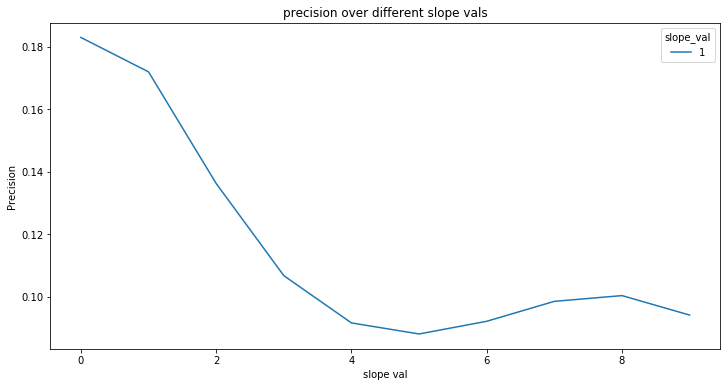

In [54]:
# seeing for which slopes we achieved better results
# defining differen environments for different slopes
slope_vals = [1]
train_metrics = pd.DataFrame([])
test_metrics = pd.DataFrame([])

for slope_val in slope_vals:
    path_strategic = f"./tests/slope_test_{slope_val}/strategic"

    # reading metrics
    train_metric = pd.read_csv(path_strategic + '/train_metrics.csv')
    train_metric["slope_val"] = slope_val
    train_metrics = pd.concat([train_metrics, train_metric])

    test_metric = pd.read_csv(path_strategic + '/test_metrics.csv')
    test_metric["slope_val"] = slope_val
    test_metrics = pd.concat([test_metrics, test_metric])

print(test_metrics["burden"])
# test_metrics["burden"] = 


# TODO: results are not good (in precision, recall and ndcg), maybe there is a problem with the model. implement naive approach (strategic data and non-strategic model) and compare
# plotting
(
    test_metrics
    .pivot(
        index='epoch num',
        columns='slope_val',
        values='burden',
    )
    .plot.line(
        title='precision over different slope vals',
        xlabel='slope val',
        ylabel='Precision',
        figsize=(12,6),
    )
)
plt.show()


### Experiment 2: Burden vs. Accuracy for different k values

In [ ]:
# defining 3 differen environments for 3 different models: low k, k, and high k
k_vals = [??????]


for k in k_vals:
    # training with different slopes
    env_params = {'noisyscale' : 0.01,
                'n_features' : 5,
                'k' : k,
                'k_tag' : k,
                'n_users': 200,
                'slope_low' : ???????,
                'slope_high' : ???????,
                'acp_reward' : 0.6,
                'funcs' : funcs,
                'funcs_batch' : funcs_batch,
                'scale' : 1}
    
    rank_env = RankingEnv(**env_params)
    model = MyStrategicModel(batch_size=env_params['n_users'], env=rank_env, strategic=True)
    
    # generate train and test sets
    X_train, R_train, y_train = rank_env.generate_dataset()
    X_test, R_test, y_test = rank_env.generate_dataset()

    path_strategic = f"./tests/k_test_{k}/strategic"
    epochs = 10
    batch_size = env_params['n_users']
    total = []
    ccp = []

    print('now training strategic model')
    strategic_train_metrics, strategic_test_metrics = model.fit(path_strategic, X_train, R_train, X_test, R_test,
                        opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                        batch_size=batch_size, epochs=epochs, verbose=True,
                    comment="batched")

    total_time = model.total_time
    ccp_time = model.ccp_time
    total.append(total_time)
    ccp.append(ccp_time)

    # saving baseline
    pd.DataFrame(np.array(total)).to_csv(path_strategic + '/total_timing_results.csv')
    pd.DataFrame(np.array(ccp)).to_csv(path_strategic + '/ccp_timing_results.csv')
    pd.DataFrame(strategic_train_metrics).to_csv(path_strategic + '/train_metrics.csv')
    pd.DataFrame(strategic_test_metrics).to_csv(path_strategic + '/test_metrics.csv')
        

### Experiment 3: Burden vs. Accuracy for different k tag values